In [31]:
# Import MNIST dataset

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [32]:
# Flip 3% of pixels
randMatrixSet = np.random.rand(60000, 28, 28)
flipFlags = randMatrixSet >= 0.97
x_train_flipped1 = np.where(flipFlags, 255-x_train, x_train)

# do it again
randMatrixSet = np.random.rand(60000, 28, 28)
flipFlags = randMatrixSet >= 0.97
x_train_flipped2 = np.where(flipFlags, 255-x_train, x_train)


# flip 3% of test pixels
randMatrixSet = np.random.rand(10000, 28, 28)
flipFlags = randMatrixSet >= 0.97
x_test_flipped = np.where(flipFlags, 255-x_test, x_test)

In [33]:
# concatinate sets
x_train_flipped = np.concatenate((x_train_flipped1, x_train_flipped2), axis=0)
x_train = np.concatenate((x_train, x_train), axis=0)

# normalize sets
x_train_flipped_norm = x_train_flipped.astype('float32') / 255.
x_train_norm = x_train.astype('float32') / 255.
x_test_flipped_norm = x_test_flipped.astype('float32') / 255.
x_test_norm = x_test.astype('float32') / 255.

# reshape sets
x_train_noisy = np.reshape(x_train_flipped_norm, (len(x_train_flipped_norm),28,28,1))
x_train = np.reshape(x_train_norm, (len(x_train_norm),28,28,1))
x_test_noisy = np.reshape(x_test_flipped_norm, (len(x_test_flipped_norm),28,28,1))
x_test = np.reshape(x_test_norm, (len(x_test_norm),28,28,1))

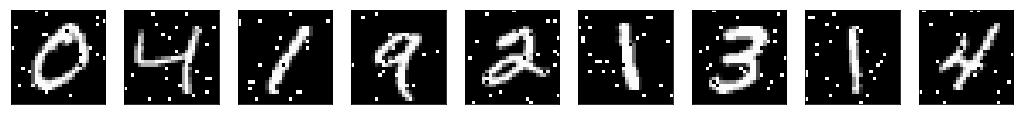

In [34]:
# plot noisy data
n=10
plt.figure(figsize=(20,2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_flipped_norm[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [35]:
# import tools necessary for implementation of convolutional autoencoder
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt

In [36]:
# Implementation of convolutional autoencoder -- varitation #1
# this first method is very verbose so that I can see exactly what's going on
# apologies if it's too wordy


# input placeholder
input_img = Input(shape=(28,28,1))

# parameters (that i'm willing to mess with)
filters = 16 # dim of output space of layer; # of output filters in the convolutn
kernel_size = (2,2) # width & height of convolution window
strides = (1,1) # strides of conv window along width,height (unused)
activation = "relu" # activation function to use; options: softmax, elu, softplus, 
#                     softsign, relu, tanh, sigmoid, hard_sigmoid, linear

# first convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(input_img)
print(x.get_shape())
# downscale the spatial dimensions
pool_size = (2,2) # downscaling factor; halve the input in both width & height
x = MaxPooling2D(pool_size, padding='same')(x)

# second convolutional layer
x = Conv2D(filters, (2,2), activation='relu', padding='same')(x)

# final downscale to produce encoded representation of input
encoded = MaxPooling2D((2,2), padding='same')(x)
# representation of input should be (filters/2/2, filters/2/2, filters) dimensional

# start decoding process

# third convolutional layer
x = Conv2D(filters, (2,2), activation='relu', padding='same')(encoded)

# upsample to higher dimensional space
x = UpSampling2D((2,2))(x)

# fourth convolutional layer
x = Conv2D(filters, (2,2), activation='relu', padding='same')(x)

# final upsample to reproduce data with initial dimensions
x = UpSampling2D((2,2))(x)

# decode the encoded data
decoded = Conv2D(1, (2,2), activation='sigmoid', padding='same')(x)

# create model object and compile it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[metrics.mean_squared_error])

(?, 28, 28, 16)


In [37]:
# sample from data
import random
random.seed(19930614)
rand_train_index = random.sample(range(0,120000+1), 12000)
x_train_noisy = x_train_noisy[ rand_train_index ]
x_train = x_train[ rand_train_index ]

In [38]:
# train the autoencoder!
hist1 = autoencoder.fit(x_train_noisy, x_train,
                        epochs=100,
                        batch_size=100,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test),
                        verbose=2)

Train on 12000 samples, validate on 10000 samples
Epoch 1/100
1s - loss: 0.4201 - mean_squared_error: 0.1172 - val_loss: 0.2291 - val_mean_squared_error: 0.0550
Epoch 2/100
1s - loss: 0.1980 - mean_squared_error: 0.0446 - val_loss: 0.1788 - val_mean_squared_error: 0.0388
Epoch 3/100
1s - loss: 0.1766 - mean_squared_error: 0.0382 - val_loss: 0.1703 - val_mean_squared_error: 0.0363
Epoch 4/100
1s - loss: 0.1706 - mean_squared_error: 0.0363 - val_loss: 0.1678 - val_mean_squared_error: 0.0355
Epoch 5/100
1s - loss: 0.1657 - mean_squared_error: 0.0347 - val_loss: 0.1632 - val_mean_squared_error: 0.0339
Epoch 6/100
1s - loss: 0.1621 - mean_squared_error: 0.0334 - val_loss: 0.1575 - val_mean_squared_error: 0.0319
Epoch 7/100
1s - loss: 0.1575 - mean_squared_error: 0.0318 - val_loss: 0.1563 - val_mean_squared_error: 0.0314
Epoch 8/100
1s - loss: 0.1528 - mean_squared_error: 0.0301 - val_loss: 0.1488 - val_mean_squared_error: 0.0288
Epoch 9/100
1s - loss: 0.1484 - mean_squared_error: 0.0285 - v

In [39]:
# make predictions on lossy test data
decoded_imgs = autoencoder.predict(x_test_noisy)

In [40]:
from sklearn.metrics import mean_squared_error

In [41]:
# calc MSE for decoded & true pairs
mseList = []
for i in range(len(decoded_imgs)):
    true = x_test[i].reshape(28,28)
    pred = decoded_imgs[i].reshape(28,28)
    mse = mean_squared_error(true,pred)
    mseList.append(mse)

In [42]:
# sort data by mse value
sorted_indexes = np.argsort(mseList)
sorted_decoded_imgs = decoded_imgs[ sorted_indexes ]
sorted_x_test_noisy = x_test_noisy[ sorted_indexes ]

In [43]:
# extract 10 best and 10 worst
best_pred = sorted_decoded_imgs[0:10,:,:,:]
best_true = sorted_x_test_noisy[0:10,:,:,:]
worst_pred = sorted_decoded_imgs[-10:,:,:,:]
worst_true = sorted_x_test_noisy[-10:,:,:,:]

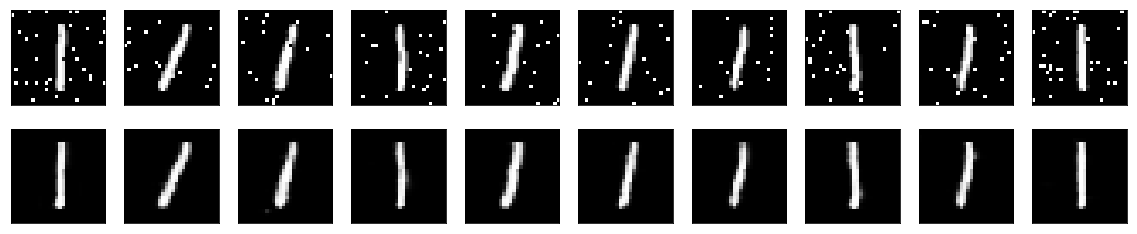

In [44]:
# plot best results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(best_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(best_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

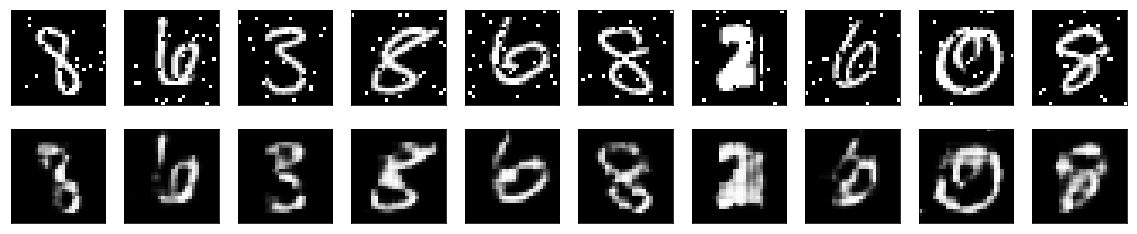

In [45]:
# plot worst results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(worst_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(worst_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
# Implementation of convolutional autoencoder -- varitation #2

# input placeholder
input_img = Input(shape=(28,28,1))

# parameters (that i'm willing to mess with)
filters = 32 # dim of output space of layer; # of output filters in the convolutn
kernel_size = (3,3) # width & height of convolution window
strides = (2,2) # strides of conv window along width,height (unused)
activation = "tanh" # activation function to use; options: softmax, elu, softplus, 
#                     softsign, relu, tanh, sigmoid, hard_sigmoid, linear

# first convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(input_img)

# downscale the spatial dimensions
pool_size = (2,2) # downscaling factor; halve the input in both width & height
x = MaxPooling2D(pool_size, padding='same')(x)

# second convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)

# final downscale to produce encoded representation of input
encoded = MaxPooling2D((2,2), padding='same')(x)
# representation of input should be (filters/2/2, filters/2/2, filters) dimensional

# start decoding process

# third convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(encoded)

# upsample to higher dimensional space
x = UpSampling2D((2,2))(x)

# fourth convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)

# final upsample to reproduce data with initial dimensions
x = UpSampling2D((2,2))(x)

# decode the encoded data
decoded = Conv2D(1, kernel_size, activation=activation, padding='same')(x)

# create model object and compile it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[metrics.mean_squared_error])

In [47]:
# train the autoencoder!
hist2 = autoencoder.fit(x_train_noisy, x_train,
                        epochs=100,
                        batch_size=100,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test),
                        verbose=2)

Train on 12000 samples, validate on 10000 samples
Epoch 1/100
1s - loss: 0.1991 - mean_squared_error: 0.0563 - val_loss: 0.1404 - val_mean_squared_error: 0.0605
Epoch 2/100
1s - loss: 0.1299 - mean_squared_error: 0.0826 - val_loss: 0.1202 - val_mean_squared_error: 0.1010
Epoch 3/100
1s - loss: 0.1179 - mean_squared_error: 0.1131 - val_loss: 0.1161 - val_mean_squared_error: 0.0976
Epoch 4/100
1s - loss: 0.1127 - mean_squared_error: 0.1340 - val_loss: 0.1081 - val_mean_squared_error: 0.1393
Epoch 5/100
1s - loss: 0.1105 - mean_squared_error: 0.1419 - val_loss: 0.1076 - val_mean_squared_error: 0.1361
Epoch 6/100
1s - loss: 0.1078 - mean_squared_error: 0.1456 - val_loss: 0.1059 - val_mean_squared_error: 0.1582
Epoch 7/100
1s - loss: 0.1065 - mean_squared_error: 0.1546 - val_loss: 0.1042 - val_mean_squared_error: 0.1508
Epoch 8/100
1s - loss: 0.1051 - mean_squared_error: 0.1652 - val_loss: 0.1027 - val_mean_squared_error: 0.1723
Epoch 9/100
1s - loss: 0.1061 - mean_squared_error: 0.1515 - v

In [48]:
# make predictions on lossy test data
decoded_imgs = autoencoder.predict(x_test_noisy)

In [115]:
# calc MSE for decoded & true pairs
mseList = []
for i in range(len(decoded_imgs)):
    true = x_test[i].reshape(28,28)
    pred = decoded_imgs[i].reshape(28,28)
    mse = mean_squared_error(true,pred)
    mseList.append(mse)

In [116]:
# sort data by mse value
sorted_indexes = np.argsort(mseList)
sorted_decoded_imgs = decoded_imgs[ sorted_indexes ]
sorted_x_test_noisy = x_test_noisy[ sorted_indexes ]

In [117]:
# extract 10 best and 10 worst
best_pred = sorted_decoded_imgs[0:10,:,:,:]
best_true = sorted_x_test_noisy[0:10,:,:,:]
worst_pred = sorted_decoded_imgs[-10:,:,:,:]
worst_true = sorted_x_test_noisy[-10:,:,:,:]

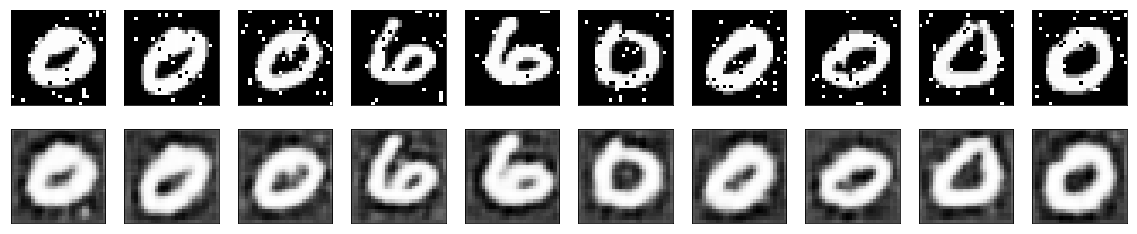

In [118]:
# plot best results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(best_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(best_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

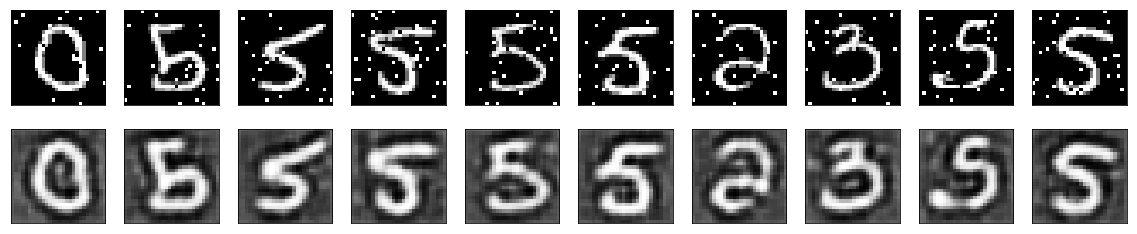

In [119]:
# plot worst results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(worst_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(worst_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
# Implementation of convolutional autoencoder -- varitation #3

# input placeholder
input_img = Input(shape=(28,28,1))

# parameters (that i'm willing to mess with)
filters =64 # dim of output space of layer; # of output filters in the convolutn
kernel_size = (1,1) # width & height of convolution window
strides = (2,2) # strides of conv window along width,height
activation = "sigmoid" # activation function to use; options: softmax, elu, softplus, 
#                     softsign, relu, tanh, sigmoid, hard_sigmoid, linear

# first convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(input_img)

# downscale the spatial dimensions
pool_size = (2,2) # downscaling factor; halve the input in both width & height
x = MaxPooling2D(pool_size, padding='same')(x)

# second convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)

# final downscale to produce encoded representation of input
encoded = MaxPooling2D((2,2), padding='same')(x)
# representation of input should be (filters/2/2, filters/2/2, filters) dimensional

# start decoding process

# third convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(encoded)

# upsample to higher dimensional space
x = UpSampling2D((2,2))(x)

# fourth convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)

# final upsample to reproduce data with initial dimensions
x = UpSampling2D((2,2))(x)

# decode the encoded data
decoded = Conv2D(1, kernel_size, activation=activation, padding='same')(x)

# create model object and compile it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[metrics.mean_squared_error])

In [7]:
# train the autoencoder!
hist3 = autoencoder.fit(x_train_noisy, x_train,
                        epochs=100,
                        batch_size=100,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test),
                        verbose=2)

Train on 12000 samples, validate on 10000 samples
Epoch 1/100
4s - loss: 0.4202 - mean_squared_error: 0.1074 - val_loss: 0.3912 - val_mean_squared_error: 0.0964
Epoch 2/100
2s - loss: 0.3878 - mean_squared_error: 0.0950 - val_loss: 0.3911 - val_mean_squared_error: 0.0964
Epoch 3/100
2s - loss: 0.3878 - mean_squared_error: 0.0950 - val_loss: 0.3912 - val_mean_squared_error: 0.0964
Epoch 4/100
2s - loss: 0.3877 - mean_squared_error: 0.0950 - val_loss: 0.3911 - val_mean_squared_error: 0.0964
Epoch 5/100
2s - loss: 0.3877 - mean_squared_error: 0.0950 - val_loss: 0.3910 - val_mean_squared_error: 0.0964
Epoch 6/100
2s - loss: 0.3876 - mean_squared_error: 0.0950 - val_loss: 0.3910 - val_mean_squared_error: 0.0964
Epoch 7/100
2s - loss: 0.3876 - mean_squared_error: 0.0950 - val_loss: 0.3909 - val_mean_squared_error: 0.0964
Epoch 8/100
2s - loss: 0.3875 - mean_squared_error: 0.0949 - val_loss: 0.3909 - val_mean_squared_error: 0.0963
Epoch 9/100
2s - loss: 0.3875 - mean_squared_error: 0.0949 - v

In [8]:
# make predictions on lossy test data
decoded_imgs = autoencoder.predict(x_test_noisy)

In [11]:
# calc MSE for decoded & true pairs
mseList = []
for i in range(len(decoded_imgs)):
    true = x_test[i].reshape(28,28)
    pred = decoded_imgs[i].reshape(28,28)
    mse = mean_squared_error(true,pred)
    mseList.append(mse)

In [12]:
# sort data by mse value
sorted_indexes = np.argsort(mseList)
sorted_decoded_imgs = decoded_imgs[ sorted_indexes ]
sorted_x_test_noisy = x_test_noisy[ sorted_indexes ]

In [13]:
# extract 10 best and 10 worst
best_pred = sorted_decoded_imgs[0:10,:,:,:]
best_true = sorted_x_test_noisy[0:10,:,:,:]
worst_pred = sorted_decoded_imgs[-10:,:,:,:]
worst_true = sorted_x_test_noisy[-10:,:,:,:]

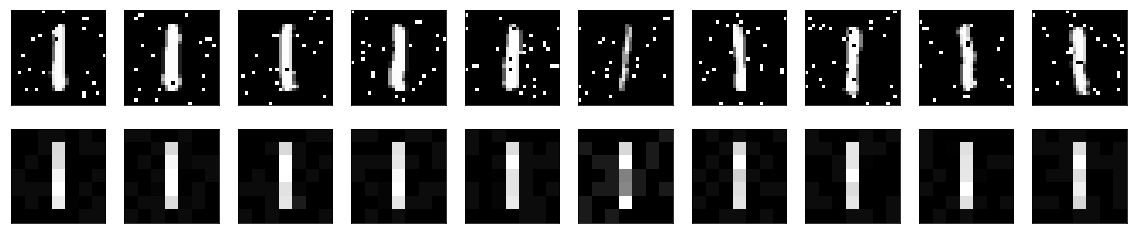

In [16]:
# plot best results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(best_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(best_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

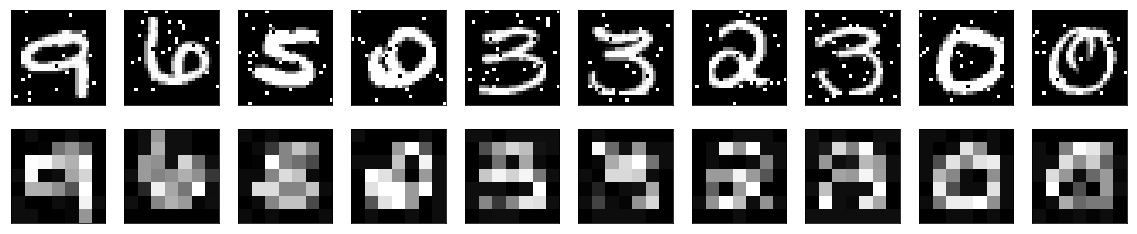

In [17]:
# plot worst results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(worst_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(worst_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
# Implementation of convolutional autoencoder -- varitation #4

# input placeholder
input_img = Input(shape=(28,28,1))

# parameters (that i'm willing to mess with)
filters =64 # dim of output space of layer; # of output filters in the convolutn
kernel_size = (5,5) # width & height of convolution window
strides = (2,2) # strides of conv window along width,height
activation = "hard_sigmoid" # activation function to use; options: softmax, elu, softplus, 
#                     softsign, relu, tanh, sigmoid, hard_sigmoid, linear

# first convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(input_img)

# downscale the spatial dimensions
pool_size = (2,2) # downscaling factor; halve the input in both width & height
x = MaxPooling2D(pool_size, padding='same')(x)

# second convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)

# final downscale to produce encoded representation of input
encoded = MaxPooling2D((2,2), padding='same')(x)
# representation of input should be (filters/2/2, filters/2/2, filters) dimensional

# start decoding process

# third convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(encoded)

# upsample to higher dimensional space
x = UpSampling2D((2,2))(x)

# fourth convolutional layer
x = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)

# final upsample to reproduce data with initial dimensions
x = UpSampling2D((2,2))(x)

# decode the encoded data
decoded = Conv2D(1, kernel_size, activation=activation, padding='same')(x)

# create model object and compile it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[metrics.mean_squared_error])

In [19]:
# train the autoencoder!
hist4 = autoencoder.fit(x_train_noisy, x_train,
                        epochs=100,
                        batch_size=100,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test),
                        verbose=2)

Train on 12000 samples, validate on 10000 samples
Epoch 1/100
3s - loss: 0.3407 - mean_squared_error: 0.0862 - val_loss: 0.3015 - val_mean_squared_error: 0.0716
Epoch 2/100
3s - loss: 0.2878 - mean_squared_error: 0.0722 - val_loss: 0.2765 - val_mean_squared_error: 0.0700
Epoch 3/100
3s - loss: 0.2812 - mean_squared_error: 0.0704 - val_loss: 0.2802 - val_mean_squared_error: 0.0698
Epoch 4/100
3s - loss: 0.2791 - mean_squared_error: 0.0699 - val_loss: 0.2738 - val_mean_squared_error: 0.0691
Epoch 5/100
3s - loss: 0.2773 - mean_squared_error: 0.0698 - val_loss: 0.2742 - val_mean_squared_error: 0.0694
Epoch 6/100
3s - loss: 0.2802 - mean_squared_error: 0.0702 - val_loss: 0.2950 - val_mean_squared_error: 0.0745
Epoch 7/100
3s - loss: 0.2755 - mean_squared_error: 0.0691 - val_loss: 0.2738 - val_mean_squared_error: 0.0692
Epoch 8/100
3s - loss: 0.2765 - mean_squared_error: 0.0695 - val_loss: 0.2721 - val_mean_squared_error: 0.0690
Epoch 9/100
3s - loss: 0.2767 - mean_squared_error: 0.0695 - v

In [20]:
# make predictions on lossy test data
decoded_imgs = autoencoder.predict(x_test_noisy)

In [21]:
# calc MSE for decoded & true pairs
mseList = []
for i in range(len(decoded_imgs)):
    true = x_test[i].reshape(28,28)
    pred = decoded_imgs[i].reshape(28,28)
    mse = mean_squared_error(true,pred)
    mseList.append(mse)

In [22]:
# sort data by mse value
sorted_indexes = np.argsort(mseList)
sorted_decoded_imgs = decoded_imgs[ sorted_indexes ]
sorted_x_test_noisy = x_test_noisy[ sorted_indexes ]

In [23]:
# extract 10 best and 10 worst
best_pred = sorted_decoded_imgs[0:10,:,:,:]
best_true = sorted_x_test_noisy[0:10,:,:,:]
worst_pred = sorted_decoded_imgs[-10:,:,:,:]
worst_true = sorted_x_test_noisy[-10:,:,:,:]

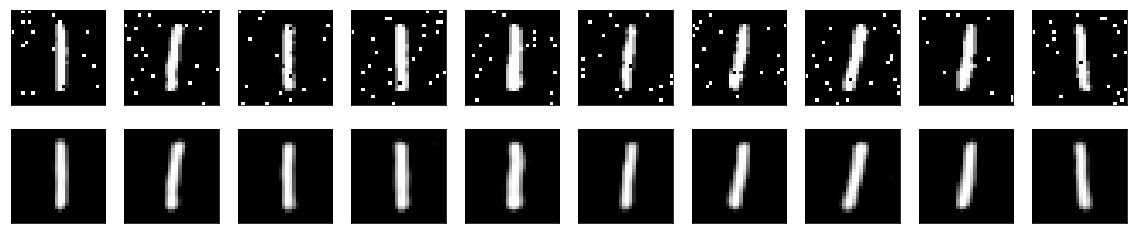

In [24]:
# plot best results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(best_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(best_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

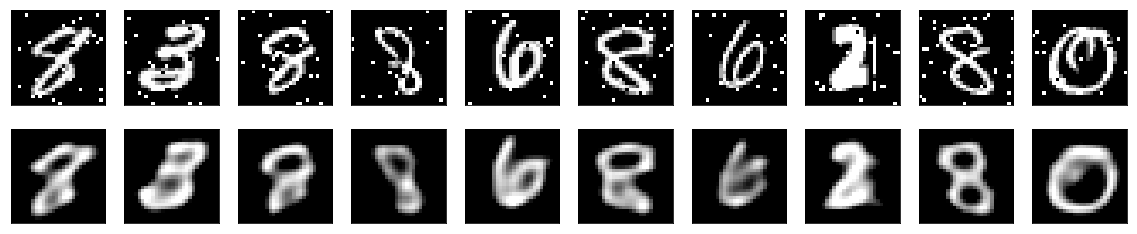

In [25]:
# plot worst results
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(worst_true[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(worst_pred[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Autoencoder variation #1

      filters per layer=16, kernel size=(2,2), activation func=relu

      number of layers=4
      


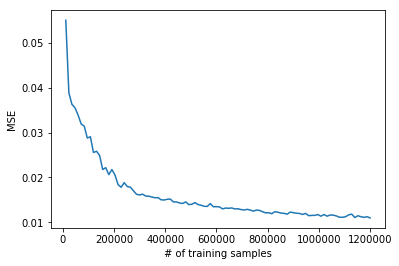

Autoencoder variation #2

      filters per layer=32, kernel size=(3,3), activation func=tanh

      number of layers=4
      


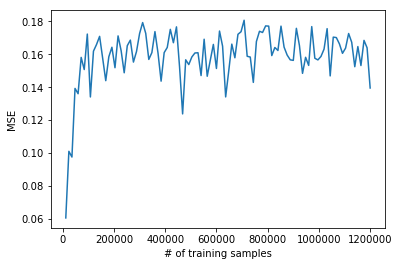

Autoencoder variation #3

      filters per layer=64, kernel size=(1,1), activation func=sigmoid

      number of layers=4
      


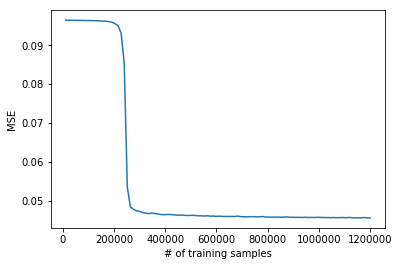

Autoencoder variation #4

      filters per layer=64, kernel size=(5,5), activation func=hard_sigmoid

      number of layers=4
      


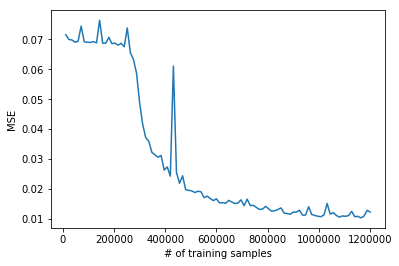

In [49]:
# plot MSE for all 4 implementations
xvals = [i+1 for i in range(len(hist1.history['val_mean_squared_error']))]
xvalsTrue = [i*12000 for i in xvals]

filters = 16 # dim of output space of layer; # of output filters in the convolutn
kernel_size = (2,2) # width & height of convolution window
strides = (1,1) # strides of conv window along width,height (unused)
activation = "relu"

# variation 1
print('''Autoencoder variation #1\n
      filters per layer=16, kernel size=(2,2), activation func=relu\n
      number of layers=4
      ''')
plt.plot(xvalsTrue,hist1.history['val_mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('# of training samples')
plt.show()
# variation 2
print('''Autoencoder variation #2\n
      filters per layer=32, kernel size=(3,3), activation func=tanh\n
      number of layers=4
      ''')
plt.plot(xvalsTrue,hist2.history['val_mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('# of training samples')
plt.show()
# variation 3
print('''Autoencoder variation #3\n
      filters per layer=64, kernel size=(1,1), activation func=sigmoid\n
      number of layers=4
      ''')
plt.plot(xvalsTrue,hist3.history['val_mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('# of training samples')
plt.show()
# variation 4
print('''Autoencoder variation #4\n
      filters per layer=64, kernel size=(5,5), activation func=hard_sigmoid\n
      number of layers=4
      ''')
plt.plot(xvalsTrue,hist4.history['val_mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('# of training samples')

plt.show()


analysis = '''
Variation 1 was the closest autoencoder to the example on the keras blog. The only difference is the kernel size (i.e. the size
of the convolutional window). I wanted to make sure I did everything correctly the first time around. Understandably it has a 
pretty tame looking MSE plot, at least compared to variation #2. On this autoencoder I used the 32  filters and the tanh activation function for all
layers and after looking at the output it dawned on me that the activation function will look more like an "r" than an "s" since
the input values range from 0 to 1 (imagine tanh but just starting at 0). With such a steep activation function and larger 
kernel size, it's no surprise that the "best" images were those with large patches of white pixels (since the neurons are easily
activated, more pixels are decoded as "white"). This is also the explanation for the fuzziness of the pictures. 
pictures and subsequently the wild MSE plot. For the 3rd autoencoder I used the smallest kernel size possible, (1,1), and 64 filters
per layer. The tiny kernel size results in the blocky format of the decoded images. Further, it took about 35k samples for the
autoencoder to learn all the digits well, but the decline was dramatic compared to variation 1. Again, I'm pretty sure this is
a result of the tiny kernel size. Finally, the fourth variation seems to perform the best. The kernel size is much bigger (5,5),
while the filters per layer is large as well at 64. It also uses the hard sigmoid activation function. If I had to do another
autoencoder I'd use the relu activation function with a 5 by 5 kernel size and 64 filters per layer.
'''